<a href="https://colab.research.google.com/github/bilychka-v/numeric_methods/blob/main/lab4/lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Введіть степінь інтерполяційного полінома: 5

Час роботи методів інтерполяції:
Метод Лагранжа (рівномірні вузли): 0.021650 сек
Метод Ньютона (рівномірні вузли): 0.024142 сек
Метод Лагранжа (вузли Чебишова): 0.020843 сек
Метод Ньютона (вузли Чебишова): 0.024130 сек

Для рівномірних вузлів:

Таблиця розділених різниць:
------------------------------------------------------------------------------------------------------------
              x            f(x)      f[x0...x1]      f[x0...x2]      f[x0...x3]      f[x0...x4]      f[x0...x5]
------------------------------------------------------------------------------------------------------------
       2.000000       1.000000      -1.000000       0.000000       1.041667      -0.651042       0.000000
       2.400000       0.600000      -1.000000       1.250000       0.000000      -0.651042
       2.800000       0.200000       0.000000       1.250000      -1.041667
       3.200000       0.200000       1.000000       0.000000
       3.600000  

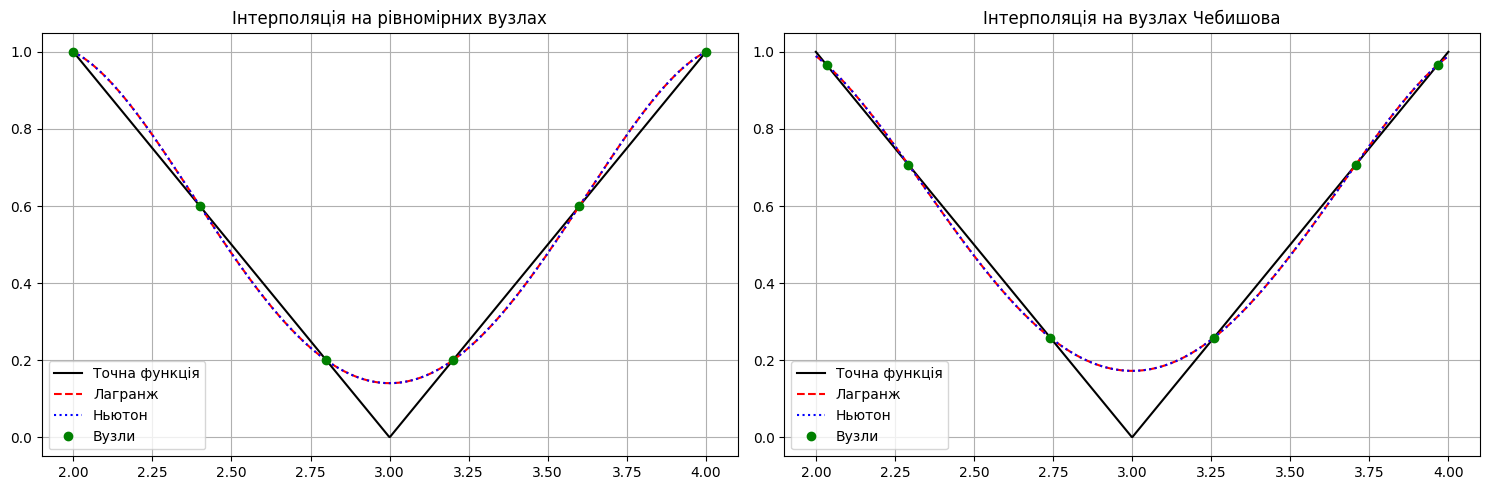

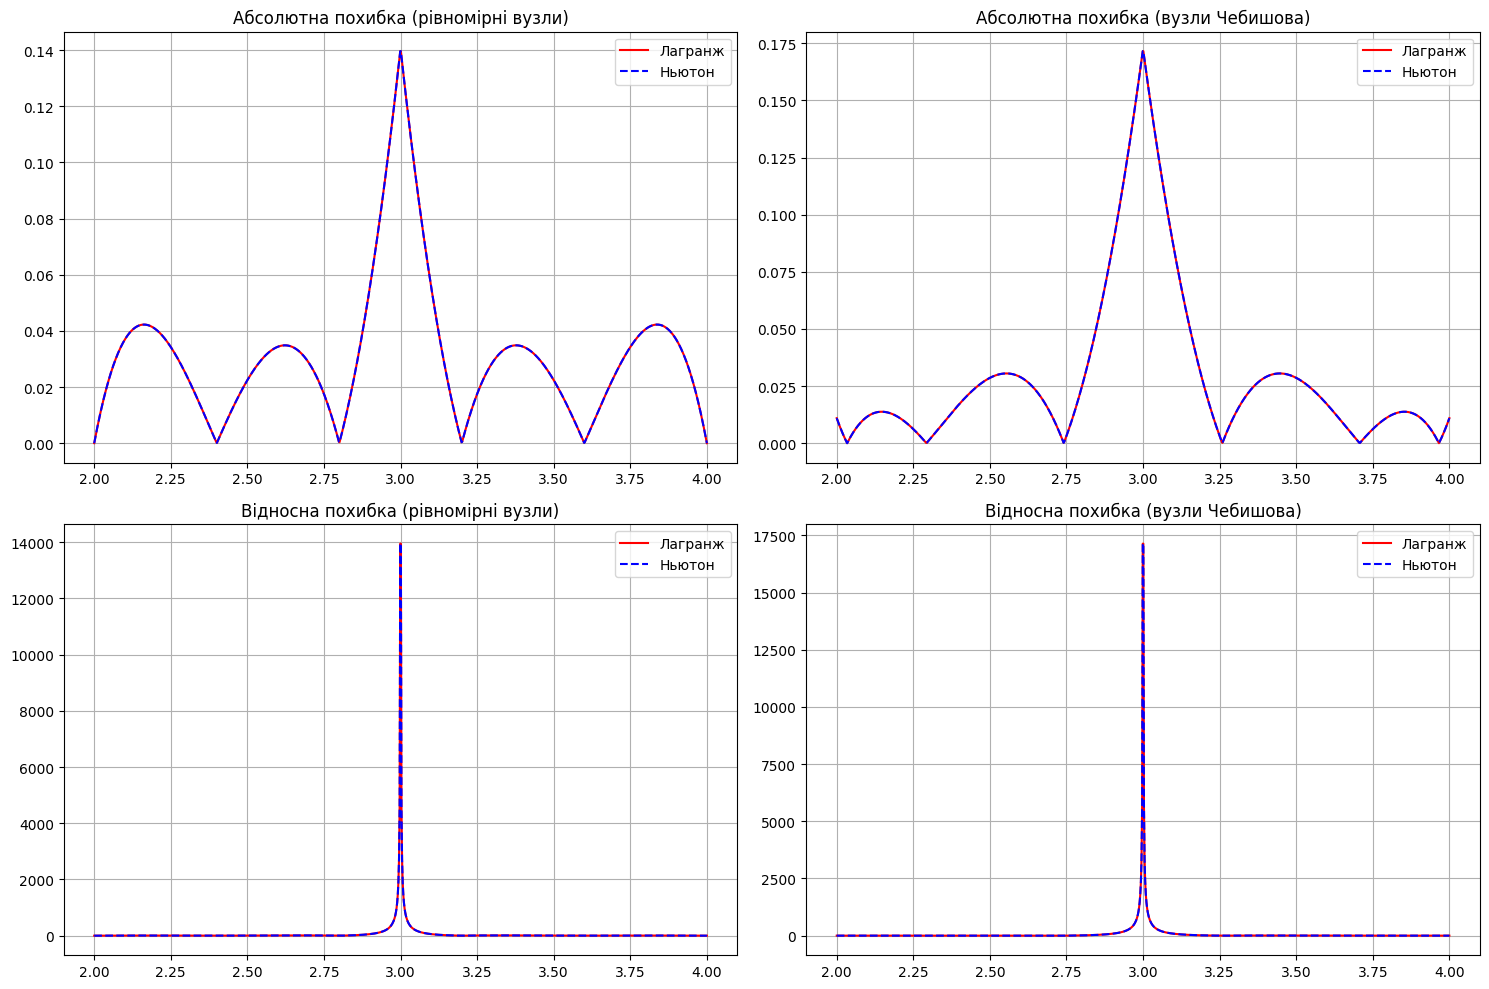

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from time import time

# Function and its derivative
def f(x):
    """Function f(x) = |x - 3|"""
    return np.abs(x - 3)

def df(x):
    """Derivative of the function f(x) = |x - 3|"""
    return np.where(x > 3, 1, -1)  # Undefined at x = 3, this covers intervals on both sides

# Monotonicity
def find_monotonicity(a, b, steps=1000):
    """Check monotonicity of the function on [a, b] and return intervals of monotonicity."""
    x = np.linspace(a, b, steps)
    derivative = df(x)

    # Determine if function is increasing or decreasing
    increasing = all(d >= 0 for d in derivative)
    decreasing = all(d <= 0 for d in derivative)

    if increasing:
        return "monotonic increasing", [(a, b)]
    elif decreasing:
        return "monotonic decreasing", [(a, b)]

    intervals = []
    start = a

    for i in range(1, len(x)):
        if derivative[i-1] * derivative[i] <= 0:
            end = (x[i-1] + x[i]) / 2
            intervals.append((start, end))
            start = end

    intervals.append((start, b))
    return "non-monotonic", intervals

# Nodes
def chebyshev_nodes(a, b, n):
    """Calculate Chebyshev nodes"""
    i = np.arange(n)
    return ((a + b) + (b - a) * np.cos((2*i + 1) * np.pi / (2*n))) / 2

def uniform_nodes(a, b, n):
    """Calculate uniform nodes"""
    return np.linspace(a, b, n)

# Lagrange Interpolation
def lagrange_interpolation(x, nodes, values):
    """Lagrange interpolation"""
    n = len(nodes)
    result = 0

    for i in range(n):
        term = values[i]
        for j in range(n):
            if i != j:
                term *= (x - nodes[j]) / (nodes[i] - nodes[j])
        result += term

    return result

# Інтерполяція Ньютона
def print_divided_differences_table(x, y):
    """Виведення таблиці розділених різниць"""
    n = len(x)
    # Створюємо матрицю для зберігання різниць
    _, f = divided_differences(x, y)

    # Виведення таблиці
    print("\nТаблиця розділених різниць:")
    print("-" * 18 * n)
    header = ["x", "f(x)"]
    for i in range(1, n):
        header.append(f"f[x0...x{i}]")
    print(f"{' '.join(f'{h:>15}' for h in header)}")
    print("-" * 18 * n)

    for i in range(n):
        row = [f"{x[i]:15.6f}", f"{f[i, 0]:15.6f}"]
        for j in range(1, n-i):
            row.append(f"{f[i, j]:15.6f}")
        print("".join(row))
    print("-" * 18 * n)

def divided_differences(x, y):
    """Обчислення розділених різниць для методу Ньютона"""
    n = len(x)
    f = np.zeros((n, n))
    f[:, 0] = y

    for j in range(1, n):
        for i in range(n - j):
            f[i, j] = (f[i + 1, j - 1] - f[i, j - 1]) / (x[i + j] - x[i])

    return f[0], f

def newton_interpolation(x, nodes, values):
    """Інтерполяція методом Ньютона"""
    coef, _ = divided_differences(nodes, values)
    n = len(nodes)
    result = coef[0]

    for i in range(1, n):
        term = coef[i]
        for j in range(i):
            term *= (x - nodes[j])
        result += term

    return result

# Обчислення похибок
def calculate_errors(x_plot, y_exact, y_interpolated):
    """Обчислення абсолютної та відносної похибок"""
    absolute_error = np.abs(np.array(y_exact) - np.array(y_interpolated))
    relative_error = absolute_error / (np.array(y_exact) + 1e-10) * 100
    return absolute_error, relative_error

def calculate_inverse_errors(y_values, x_inverse_values, y_inverse_values):
    """Обчислення похибок для оберненої інтерполяції"""
    # Знаходження найближчих точних значень для кожного інтерпольованого x
    absolute_errors = []
    relative_errors = []

    for x_inv, y_inv in zip(x_inverse_values, y_inverse_values):
        # Знаходимо точне значення x для поточного y
        x_exact_p = np.sqrt(5/y_inv - 1)
        x_exact_n = -np.sqrt(5/y_inv - 1)

        # Вибираємо найближче точне значення
        error_p = abs(x_inv - x_exact_p)
        error_n = abs(x_inv - x_exact_n)

        if error_p <= error_n:
            abs_error = error_p
            rel_error = (error_p / abs(x_exact_p)) * 100
        else:
            abs_error = error_n
            rel_error = (error_n / abs(x_exact_n)) * 100

        absolute_errors.append(abs_error)
        relative_errors.append(rel_error)

    return absolute_errors, relative_errors

# Інверсна інтерполяція
def inverse_interpolation(y_value, x_nodes, y_nodes, monotonicity):
    """
    Обернена інтерполяція для знаходження x такого, що f(x) = y_value
    """
    def target_function(x, nodes, values):
        return lagrange_interpolation(x, nodes, values) - y_value

    # Перевірка діапазону
    y_min, y_max = min(y_nodes), max(y_nodes)
    if y_value < y_min or y_value > y_max:
        return []

    if not monotonicity[0] == "non-monotonic":
        x_initial_guesses = [x_nodes[0], x_nodes[-1]]
        solutions = []
        for guess in x_initial_guesses:
            try:
                x_solution = fsolve(lambda x: target_function(x, x_nodes, y_nodes),
                                     guess,
                                     full_output=True)
                if x_solution[2] == 1:
                    solutions.append(x_solution[0][0])
            except:
                continue
        return list(set(solutions))

    intervals = monotonicity[1]
    solutions = []

    for interval in intervals:
        # Вибір вузлів для інтервалу
        mask = [(x >= interval[0]) and (x <= interval[1]) for x in x_nodes]
        x_sub_nodes = [x for x, m in zip(x_nodes, mask) if m]
        y_sub_nodes = [y for y, m in zip(y_nodes, mask) if m]

        if len(x_sub_nodes) < 2:
            continue

        # Використання декількох початкових наближень
        x_guesses = np.linspace(interval[0], interval[1], 5)  # Збільшено кількість початкових наближень

        for x_guess in x_guesses:
            try:
                x_solution = fsolve(lambda x: target_function(x, x_sub_nodes, y_sub_nodes),
                                     x_guess,
                                     full_output=True)
                if (x_solution[2] == 1 and
                    interval[0] <= x_solution[0][0] <= interval[1] and
                    abs(target_function(x_solution[0][0], x_sub_nodes, y_sub_nodes)) < 1e-10):
                    solutions.append(x_solution[0][0])
            except:
                continue

    # Видалення дублікатів
    if solutions:
        unique_solutions = []
        for sol in solutions:
            if not any(abs(sol - existing) < 1e-10 for existing in unique_solutions):
                unique_solutions.append(sol)
        return sorted(unique_solutions)

    return []

def plot_inverse_interpolation(x_nodes, y_nodes, monotonicity):
    """Функція для побудови графіка оберненої функції"""
    # Генерація точок для оберненої функції
    y_values = np.linspace(min(y_nodes), max(y_nodes), 50)
    x_inverse_values = []
    y_inverse_values = []

    for y_val in y_values:
        solutions = inverse_interpolation(y_val, x_nodes, y_nodes, monotonicity)
        for x_sol in solutions:
            x_inverse_values.append(x_sol)
            y_inverse_values.append(y_val)

    # Побудова точок оберненої функції
    plt.scatter(y_inverse_values, x_inverse_values, color='red', s=30, label='Обернена інтерполяція')

    # Побудова точної оберненої функції
    y_exact = np.linspace(min(y_nodes), max(y_nodes), 1000)
    x_exact_pos = np.sqrt(5/y_exact - 1)  # Додатна гілка
    x_exact_neg = -np.sqrt(5/y_exact - 1)  # Від'ємна гілка

    plt.plot(y_exact, x_exact_pos, 'k-', label='Точна функція')
    plt.plot(y_exact, x_exact_neg, 'k-')

    return y_values, x_inverse_values, y_inverse_values

def main():
    # Введення степеня інтерполяційного полінома
    n = int(input("Введіть степінь інтерполяційного полінома: "))

    # Визначення відрізка
    a, b = 2, 4

    # Створення вузлів
    uniform = uniform_nodes(a, b, n+1)
    chebyshev = chebyshev_nodes(a, b, n+1)

    # Обчислення значень функції у вузлах
    uniform_values = [f(x) for x in uniform]
    chebyshev_values = [f(x) for x in chebyshev]

    # 1. Пряма інтерполяція та час виконання
    x_plot = np.linspace(a, b, 1000)
    y_plot = [f(x) for x in x_plot]

    print("\nЧас роботи методів інтерполяції:")

    # Рівномірні вузли
    start_time = time()
    y_lagrange_uniform = [lagrange_interpolation(x, uniform, uniform_values) for x in x_plot]
    print(f"Метод Лагранжа (рівномірні вузли): {time() - start_time:.6f} сек")

    start_time = time()
    y_newton_uniform = [newton_interpolation(x, uniform, uniform_values) for x in x_plot]
    print(f"Метод Ньютона (рівномірні вузли): {time() - start_time:.6f} сек")

    # Вузли Чебишова
    start_time = time()
    y_lagrange_chebyshev = [lagrange_interpolation(x, chebyshev, chebyshev_values) for x in x_plot]
    print(f"Метод Лагранжа (вузли Чебишова): {time() - start_time:.6f} сек")

    start_time = time()
    y_newton_chebyshev = [newton_interpolation(x, chebyshev, chebyshev_values) for x in x_plot]
    print(f"Метод Ньютона (вузли Чебишова): {time() - start_time:.6f} сек")

    # 2. Таблиці розділених різниць
    print("\nДля рівномірних вузлів:")
    print_divided_differences_table(uniform, uniform_values)

    print("\nДля вузлів Чебишова:")
    print_divided_differences_table(chebyshev, chebyshev_values)

    # 3. Графіки прямої інтерполяції
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(x_plot, y_plot, 'k-', label='Точна функція')
    plt.plot(x_plot, y_lagrange_uniform, 'r--', label='Лагранж')
    plt.plot(x_plot, y_newton_uniform, 'b:', label='Ньютон')
    plt.plot(uniform, uniform_values, 'go', label='Вузли')
    plt.title('Інтерполяція на рівномірних вузлах')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(x_plot, y_plot, 'k-', label='Точна функція')
    plt.plot(x_plot, y_lagrange_chebyshev, 'r--', label='Лагранж')
    plt.plot(x_plot, y_newton_chebyshev, 'b:', label='Ньютон')
    plt.plot(chebyshev, chebyshev_values, 'go', label='Вузли')
    plt.title('Інтерполяція на вузлах Чебишова')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('interpolation_report.png')

    # 4. Похибки прямої інтерполяції
    abs_err_lagrange_uniform, rel_err_lagrange_uniform = calculate_errors(x_plot, y_plot, y_lagrange_uniform)
    abs_err_newton_uniform, rel_err_newton_uniform = calculate_errors(x_plot, y_plot, y_newton_uniform)
    abs_err_lagrange_chebyshev, rel_err_lagrange_chebyshev = calculate_errors(x_plot, y_plot, y_lagrange_chebyshev)
    abs_err_newton_chebyshev, rel_err_newton_chebyshev = calculate_errors(x_plot, y_plot, y_newton_chebyshev)

    # 5. Графіки похибок прямої інтерполяції
    plt.figure(figsize=(15, 10))

    # Абсолютні похибки для рівномірних вузлів
    plt.subplot(2, 2, 1)
    plt.plot(x_plot, abs_err_lagrange_uniform, 'r-', label='Лагранж')
    plt.plot(x_plot, abs_err_newton_uniform, 'b--', label='Ньютон')
    plt.title('Абсолютна похибка (рівномірні вузли)')
    plt.legend()
    plt.grid(True)

    # Абсолютні похибки для вузлів Чебишова
    plt.subplot(2, 2, 2)
    plt.plot(x_plot, abs_err_lagrange_chebyshev, 'r-', label='Лагранж')
    plt.plot(x_plot, abs_err_newton_chebyshev, 'b--', label='Ньютон')
    plt.title('Абсолютна похибка (вузли Чебишова)')
    plt.legend()
    plt.grid(True)

    # Відносні похибки для рівномірних вузлів
    plt.subplot(2, 2, 3)
    plt.plot(x_plot, rel_err_lagrange_uniform, 'r-', label='Лагранж')
    plt.plot(x_plot, rel_err_newton_uniform, 'b--', label='Ньютон')
    plt.title('Відносна похибка (рівномірні вузли)')
    plt.legend()
    plt.grid(True)

    # Відносні похибки для вузлів Чебишова
    plt.subplot(2, 2, 4)
    plt.plot(x_plot, rel_err_lagrange_chebyshev, 'r-', label='Лагранж')
    plt.plot(x_plot, rel_err_newton_chebyshev, 'b--', label='Ньютон')
    plt.title('Відносна похибка (вузли Чебишова)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('errors_report.png')

    plt.show()

if __name__ == "__main__":
    main()
